<a href="https://colab.research.google.com/github/linus-nb/dl4aed_project/blob/master_github/Code/DLNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
from pathlib import Path
import json
import glob
import numpy as np
import librosa
from librosa import display
import matplotlib.pyplot as plt
from DLNet_functions import preprocess_wrapper
import os
import tensorflow as tf
assert tf.__version__ >= "2.0"
# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE
DATA_PATH = '/content/drive/MyDrive'


In [25]:
# Create Config for preprocessing and pipeline parameters

config = {'sr': 44100,
          'audio_length': 1,
          'mono': True,
          'n_mels': 64,
          'n_fft': 1024,
          'hop_length': 256,
          'win_length': 512,
          'window': 'hann',
          'center': True,
          'pad_mode': 'reflect',
          'power': 2.0,
          }

# save number of frames from length in samples divided by fft hop length
config['n_frames'] = int(
    config['sr']*config['audio_length']/config['hop_length']) + 1

# save input shape for model
config['input_shape'] = (config['n_mels'], config['n_frames'], 1)

# save config
with open('DLNet_config.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

# Create wrapper object:
ds_config = './dataset_config.json'
wrapper = preprocess_wrapper(config, ds_config, binary=False)

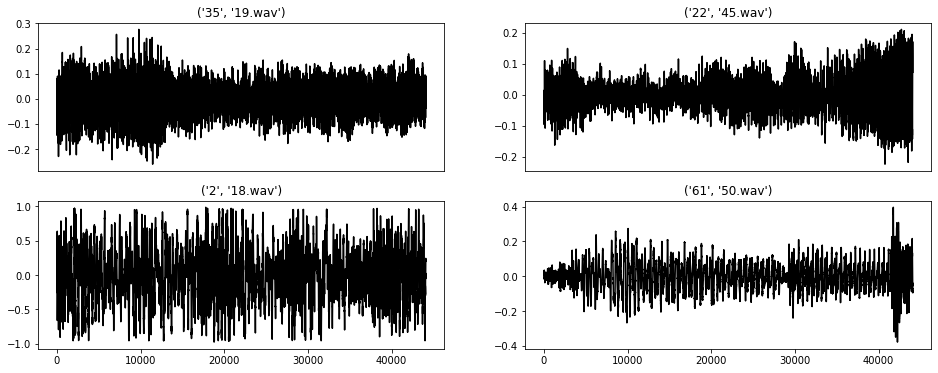

In [20]:
# VISUALIZE WAVEFORMS
# get all wav files
fps = glob.glob(os.path.join(DATA_PATH, 'MedleyDB', '*_wav', '**', '*.wav'), recursive=True)
fps_random = []
np.random.seed(9)

# setup subplot
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, sr=None)
        ax[r][c].plot(audio, c='k')
        # ax[r][c].axis('off')
        ax[r][c].set_title(Path(fp_random).parts[-2:])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)


/usr/local/lib/python3.6/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


Melspec shape: (64, 173)
Stft shape: (513, 173)
Total data points in mel-spectrogram:       11072
Total data points in stft-spectrogram: 88749
-> Data Reduction by factor:       8.015625


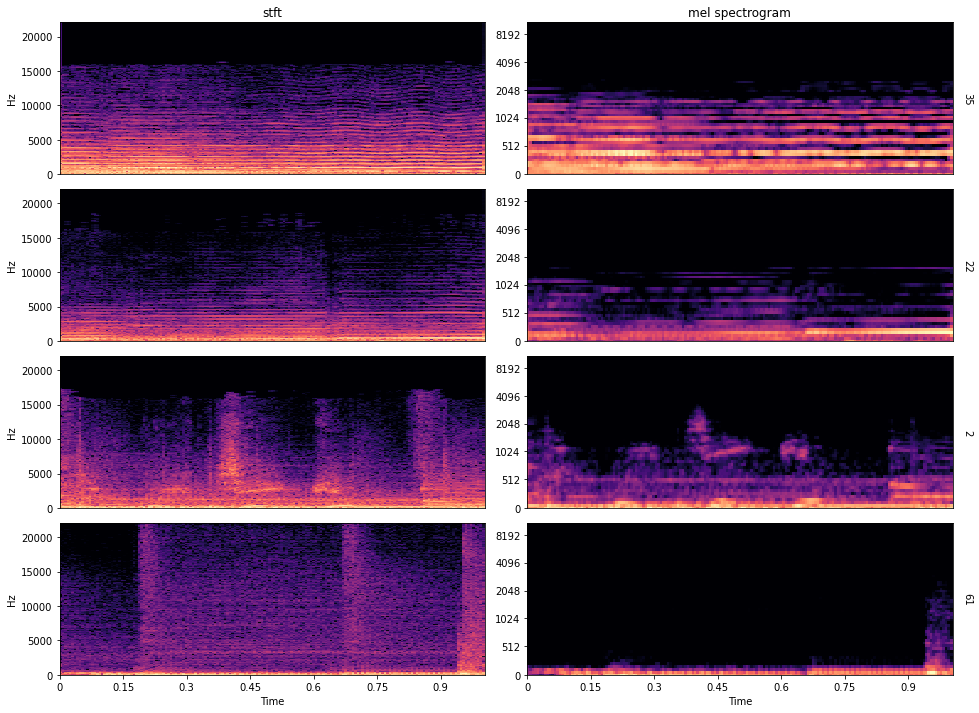

In [21]:
# VISUALIZE SPECTROGRAMS
# setup subplot
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 12))

# plot some audio waveforms
for i, fp_random in enumerate(fps_random):
    audio, sr = librosa.core.load(fp_random, sr=None)

    # calculate stft
    stft = librosa.stft(audio, n_fft=config['n_fft'],
                        hop_length=config['hop_length'],
                        win_length=config['win_length'])

    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio, n_fft=config['n_fft'],
                                             hop_length=config['hop_length'],
                                             n_mels=config['n_mels'],
                                             fmax=int(config['sr']/2))
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # calculate magnitude and scale to dB
    magspec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

    # plot with librosa
    librosa.display.specshow(magspec, x_axis='time', y_axis='linear', sr=sr,
                             hop_length=256, ax=ax[i][0])
    librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=sr,
                             hop_length=256, ax=ax[i][1])

    # adjustments
    # ax[i][1].set_yticks([])
    ax[i][1].set_ylabel(Path(fp_random).parts[-2], rotation=270, labelpad=20)
    ax[i][1].yaxis.set_label_position("right")

    # settings for all axises but bottom ones
    if not i == len(fps_random) - 1:
        ax[i][0].set_xticks([])
        ax[i][1].set_xticks([])
        ax[i][0].set_xlabel('')
        ax[i][1].set_xlabel('')

    # settings for upper axises
    if i == 0:
        ax[i][0].set_title('stft')
        ax[i][1].set_title('mel spectrogram')

# adjust whitespace in between subplots
plt.subplots_adjust(hspace=0.1, wspace=0.1)

print('Melspec shape: %s' % (str(melspec.shape)))
print('Stft shape: %s' % (str(stft.shape)))
print(f'Total data points in mel-spectrogram: \
      {melspec.shape[0]*melspec.shape[1]}')
print(f'Total data points in stft-spectrogram: {stft.shape[0]*stft.shape[1]}')
print(f'-> Data Reduction by factor: \
      {(stft.shape[0]*stft.shape[1]) / (melspec.shape[0]*melspec.shape[1])}')



In [26]:
# Create dataset from MedleyDB codecs
# test_aac, train_aac = wrapper.tf_dataset_from_codec('/content/drive/MyDrive/MedleyDB/compressed_wav/ogg_vbr')
# test_wav, train_wav = wrapper.tf_dataset_from_codec('/content/drive/MyDrive/MedleyDB/uncompr_wav')
# test_dataset = test_wav.concatenate(test_aac)
# train_dataset = train_wav.concatenate(train_aac)

# Create dataset from MedleyDB and add uncompressed wav from OtherWAV
test_medley, train_medley = wrapper.tf_dataset_from_database(os.path.join(DATA_PATH, 'MedleyDB'))
test_wav, train_wav = wrapper.tf_dataset_from_codec(os.path.join(DATA_PATH, 'OtherWAV', 'uncompr_wav'))
test_dataset = test_wav.concatenate(test_medley)
train_dataset = train_wav.concatenate(train_medley)

In [27]:
print(f'Train dataset size:{len(train_dataset)}')
print(f'Test dataset size:{len(test_dataset)}')

Train dataset size:1400
Test dataset size:5800


In [28]:
train_size = len(train_dataset)
test_size = len(test_dataset)
eval_size = int(.1*train_size)

# Shuffel train data:
train_dataset = train_dataset.shuffle(buffer_size=train_size)
# Split train into train and eval set:
eval_dataset = train_dataset.take(eval_size)
eval_dataset = eval_dataset.batch(64).prefetch(AUTOTUNE)

# Train dataset
train_dataset = train_dataset.skip(eval_size)
train_dataset = train_dataset.shuffle(train_size - eval_size)
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.prefetch(AUTOTUNE)

# Prepare test dataset
test_dataset = test_dataset.batch(64).prefetch(AUTOTUNE)

tf.summary.histogram('Summary train data', train_dataset)
tf.summary.histogram('Summary test data', test_dataset)

In [30]:
tf.summary.histogram('Summary train data', train_dataset)
tf.summary.histogram('Summary test data', test_dataset)

<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [29]:
# create model architecture
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=config['input_shape']))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation="relu"))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
model.add(tf.keras.layers.GaussianDropout(0.25))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation="relu"))
model.add(tf.keras.layers.GlobalMaxPool2D())
model.add(tf.keras.layers.Dense(len(config['classes']), activation="sigmoid"))

# Define metrics
metrics = [tf.keras.metrics.TrueNegatives(),
           tf.keras.metrics.TruePositives(),
           tf.keras.metrics.FalseNegatives(),
           tf.keras.metrics.FalsePositives(),
           tf.keras.metrics.Precision(),
           tf.keras.metrics.Recall(),
           tf.keras.metrics.CategoricalAccuracy()
           ]

# compile model
n_epochs = 10
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit model
history = model.fit(train_dataset, epochs=n_epochs,
                    validation_data=eval_dataset)

# test 
model.evaluate(test_dataset)


Epoch 1/10
20/20 [==============================] - 279s 2s/step - loss: 1.5192 - accuracy: 0.4843 - val_loss: 0.6118 - val_accuracy: 0.6786
Epoch 2/10
20/20 [==============================] - 53s 2s/step - loss: 0.6330 - accuracy: 0.6902 - val_loss: 0.5316 - val_accuracy: 0.7429
Epoch 3/10
20/20 [==============================] - 53s 2s/step - loss: 0.5964 - accuracy: 0.6697 - val_loss: 0.6071 - val_accuracy: 0.7000
Epoch 4/10
20/20 [==============================] - 52s 2s/step - loss: 0.5474 - accuracy: 0.7026 - val_loss: 0.4972 - val_accuracy: 0.7714
Epoch 5/10
20/20 [==============================] - 52s 2s/step - loss: 0.5391 - accuracy: 0.7044 - val_loss: 0.5052 - val_accuracy: 0.7429
Epoch 6/10
20/20 [==============================] - 50s 2s/step - loss: 0.5227 - accuracy: 0.7211 - val_loss: 0.5689 - val_accuracy: 0.7286
Epoch 7/10
20/20 [==============================] - 53s 2s/step - loss: 0.5145 - accuracy: 0.7410 - val_loss: 0.5539 - val_accuracy: 0.7286
Epoch 8/10
20/20 [=

[0.6383706331253052, 0.6813793182373047]

In [ ]:
# setup plot
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,4))

# plot loss
ax[0].plot(range(n_epochs), history.history['loss'])
ax[0].plot(range(n_epochs), history.history['val_loss'])
ax[0].set_ylabel('loss'), ax[0].set_title('train_loss vs val_loss')

# plot accuracy
ax[1].plot(range(n_epochs), history.history['categorical_accuracy'])
ax[1].plot(range(n_epochs), history.history['val_categorical_accuracy'])
ax[1].set_ylabel('accuracy'), ax[1].set_title('train_acc vs val_acc')

# plot adjustement
for a in ax:
    a.grid(True)
    a.legend(['train','val'], loc=4)
    a.set_xlabel('num of Epochs')
plt.show()
